<font color = blue><font size = 6> 모델설명 </font></font><br>
이전에 activation을 추가한 모델에서 마지막 score x output 값들을 합치는 과정에서 Linear layer를 추가해서 가중합을 해준다

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [96]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [97]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [98]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online-learning-DLinear']

In [99]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [100]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [101]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        div_factor = x.permute(0,2,1)[:,-1,:].view(-1,1,1)
        x = x/div_factor
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            seasonal_score,trend_score = self.activation(seasonal_output),self.activation(trend_output)
            
            new_input = torch.cat([seasonal_output*seasonal_score,trend_output*trend_score],dim=1).view(-1,1,2)
        x = self.Linear_plus(new_input)
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [102]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [103]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [104]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [105]:
torch.manual_seed(42)

In [106]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [107]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
 
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 23.579491867046606 %
smape 12.615066489629578 %
smape 11.96402143229518 %
smape 11.67737810540269 %
smape 11.58763678014627 %
smape 11.710617678207264 %
smape 11.963388037524725 %
smape 11.32850008052692 %
smape 11.12235758213969 %
smape 11.216087908598414 %
smape 10.697982655892595 %
smape 10.035319035077652 %
smape 9.744233983999107 %
smape 9.946525112143037 %
smape 10.996981287560267 %
smape 11.358844185607476 %
smape 11.957030604370155 %
smape 11.583766938562977 %
smape 10.541979377729852 %
smape 9.968196032078643 %
smape 9.945097342569229 %
smape 9.809192971527924 %
smape 10.578853569881261 %
smape 11.81804293341804 %
smape 11.225015335438544 %
smape 10.200569607012454 %
smape 9.701460561121417 %
smape 9.334239473032673 %
smape 9.371871600548426 %
smape 9.997433146015245 %
smape 10.655600601992411 %
smape 11.526038003159545 %
smape 10.621329118546686 %
smape 10.138982198043177 %
smape 9.642829220110213 %
smape 9.347739063246905 %
smape 9.49820734778343 %
smape 9.936679665282

In [108]:
torch.manual_seed(42)

In [109]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [110]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
#PATH = './my/Online_Dlearning_Path'
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)
#torch.save(model,PATH+'/best_mymodel.pt') #모델의 갱신

SMAPE 0.18224470291897887 %
SMAPE 3.2978712987824106 %
SMAPE 1.4029472319707565 %
SMAPE 1.0270159935789707 %
SMAPE 0.33974204309316747 %
SMAPE 0.40672415411609103 %
SMAPE 1.7085616647473216 %
SMAPE 0.940122978961881 %
SMAPE 0.22230567564838566 %
SMAPE 0.7444426910367383 %
SMAPE 0.2802440390892116 %
SMAPE 2.4502912397620094 %
SMAPE 1.5609808316414728 %
SMAPE 1.2202393986590323 %
SMAPE 1.9446260705617533 %
SMAPE 2.0646953160694466 %
SMAPE 1.6818091741261014 %
SMAPE 0.23630610099280602 %
SMAPE 0.477120564552024 %
SMAPE 0.2606480359027046 %
SMAPE 0.8959625105026134 %
SMAPE 3.939984484022716 %
SMAPE 2.1932452721493974 %
SMAPE 0.5681045606715998 %
SMAPE 0.4367924774705898 %
SMAPE 0.8850567936842708 %
SMAPE 2.82952656228008 %
SMAPE 0.7378855222013954 %
SMAPE 0.2191971983620533 %
SMAPE 0.5694915572339596 %
SMAPE 0.3224617417108675 %
SMAPE 4.63521363478867 %
SMAPE 2.461856220537811 %
SMAPE 0.3727039406330732 %
SMAPE 0.39235275755208937 %
SMAPE 0.6220392431350774 %
SMAPE 2.476115085577476 %
SMAP

SMAPE 0.5440350300709724 %
SMAPE 2.5860341415464063 %
SMAPE 1.2253413889120566 %
SMAPE 0.5376041173039994 %
SMAPE 0.3152452838894533 %
SMAPE 0.903044602520822 %
SMAPE 0.4669187989375132 %
SMAPE 2.614506861034897 %
SMAPE 0.2738793288672241 %
SMAPE 0.8353079960397737 %
SMAPE 6.120533627294208 %
SMAPE 2.2639016945277035 %
SMAPE 0.5223288552660961 %
SMAPE 0.6024561126323533 %
SMAPE 0.44840047742764 %
SMAPE 1.1247678372219525 %
SMAPE 0.23448963941518744 %
SMAPE 3.1830148085447263 %
SMAPE 0.16978587015910307 %
SMAPE 0.5010435291042086 %
SMAPE 0.14178133423411055 %
SMAPE 0.28103349309094483 %
SMAPE 0.7745668094285065 %
SMAPE 0.28467740387441154 %
SMAPE 1.3603929606742895 %
SMAPE 0.6905567779094781 %
SMAPE 0.13925715546781703 %
SMAPE 6.958681673495448 %
SMAPE 0.5906963455345249 %
SMAPE 0.39072710489017487 %
SMAPE 0.5683280619705329 %
SMAPE 0.7876976629377167 %
SMAPE 0.2604154706598365 %
SMAPE 0.10600675947898708 %
SMAPE 0.5665776886617095 %
SMAPE 1.1535893740292522 %
SMAPE 0.4296699578262632 %

SMAPE 0.33861173847617465 %
SMAPE 0.544830157476099 %
SMAPE 0.3504636506368115 %
SMAPE 0.09412719687225035 %
SMAPE 1.7696998789688223 %
SMAPE 0.5886702925731697 %
SMAPE 0.20541430398952798 %
SMAPE 0.27181165766705817 %
SMAPE 0.16263620501558762 %
SMAPE 1.2083884955172834 %
SMAPE 0.1193548137016478 %
SMAPE 2.1795754851264064 %
SMAPE 0.8305022217100486 %
SMAPE 0.36466763816133607 %
SMAPE 1.8304592171707557 %
SMAPE 0.5200236406526528 %
SMAPE 0.3024046558321061 %
SMAPE 0.16526354787310993 %
SMAPE 0.4487268121902161 %
SMAPE 2.209867420770024 %
SMAPE 1.342096043888887 %
SMAPE 0.3451125247665914 %
SMAPE 0.2341944140061969 %
SMAPE 1.2821675959839922 %
SMAPE 3.8867459862158285 %
SMAPE 0.16415114503070072 %
SMAPE 0.3703223920892924 %
SMAPE 0.4995387127510184 %
SMAPE 0.26034637775410374 %
SMAPE 1.4126388505537761 %
SMAPE 0.19871103087098163 %
SMAPE 0.36585149712641396 %
SMAPE 0.1911106608577029 %
SMAPE 1.4483948652778054 %
SMAPE 0.15790537784232583 %
SMAPE 1.5193717385100172 %
SMAPE 0.31032976103

SMAPE 0.4557958776176747 %
SMAPE 0.23088761835366256 %
SMAPE 1.0122455110849842 %
SMAPE 0.446731008374627 %
SMAPE 0.4167015333605377 %
SMAPE 0.29057180126073945 %
SMAPE 0.37239559203226236 %
SMAPE 0.4985525983720436 %
SMAPE 1.637940633459948 %
SMAPE 0.8135725841275415 %
SMAPE 0.7352111094623979 %
SMAPE 0.7165742621873505 %
SMAPE 0.904399694656604 %
SMAPE 0.6709727746274439 %
SMAPE 0.28754387646472424 %
SMAPE 0.231472533347187 %
SMAPE 0.16641343223272997 %
SMAPE 0.8026252240924805 %
SMAPE 0.3179782062106824 %
SMAPE 1.0870674158904876 %
SMAPE 0.7016354227089323 %
SMAPE 0.2795320728155275 %
SMAPE 2.302452362215263 %
SMAPE 0.23486726126975555 %
SMAPE 0.387967749463769 %
SMAPE 0.2350632054821062 %
SMAPE 0.10786554313381201 %
SMAPE 0.4726928916279576 %
SMAPE 1.0445359443292546 %
SMAPE 1.7113508609545536 %
SMAPE 0.7389734908716719 %
SMAPE 0.7027182953088413 %
SMAPE 1.0619248158182018 %
SMAPE 0.27365630993881496 %
SMAPE 2.4488482591841603 %
SMAPE 0.4256057966140361 %
SMAPE 0.24977932576075546 

SMAPE 0.7611191015439545 %
SMAPE 0.24769784027375863 %
SMAPE 0.877588128514617 %
SMAPE 0.19085880128659483 %
SMAPE 0.2806777124878863 %
SMAPE 0.23054008176438856 %
SMAPE 1.1795150686048146 %
SMAPE 0.32827565819752635 %
SMAPE 0.28527544017561013 %
SMAPE 0.32180702207188006 %
SMAPE 0.05580678063245159 %
SMAPE 0.8566136398840172 %
SMAPE 0.8109577483592147 %
SMAPE 0.37991516589204366 %
SMAPE 0.21992013245107955 %
SMAPE 0.6208193427410151 %
SMAPE 0.47921567403318477 %
SMAPE 0.41227265186171275 %
SMAPE 0.42500998895047815 %
SMAPE 1.5835750450114574 %
SMAPE 0.4292206026948406 %
SMAPE 0.4722852049744688 %
SMAPE 0.34686447811327525 %
SMAPE 0.2308635030021833 %
SMAPE 0.19253160416047876 %
SMAPE 0.17706628937879998 %
SMAPE 0.19795419051843055 %
SMAPE 0.32616441029676935 %
SMAPE 0.9098727609525668 %
SMAPE 0.08146325742018234 %
SMAPE 0.26464322518313566 %
SMAPE 0.4255882861762075 %
SMAPE 0.11327874142762084 %
SMAPE 0.891510652803845 %
SMAPE 1.429996152775857 %
SMAPE 0.4625451639485618 %
SMAPE 0.543

SMAPE 0.37501762846295605 %
SMAPE 0.2675272525150376 %
SMAPE 0.21460247844515834 %
SMAPE 0.6496137502290367 %
SMAPE 0.6242783537709329 %
SMAPE 0.5123666490508185 %
SMAPE 0.18062395213019045 %
SMAPE 0.5141078637389 %
SMAPE 0.15527328302778187 %
SMAPE 0.7442750503205389 %
SMAPE 0.31205862351998803 %
SMAPE 0.0935128345031444 %
SMAPE 0.7731066670783093 %
SMAPE 0.34244010192094265 %
SMAPE 0.28102899825171335 %
SMAPE 0.17738066194397106 %
SMAPE 0.7402042872854508 %
SMAPE 0.23666921879703295 %
SMAPE 1.0958696669113124 %
SMAPE 2.441071129811462 %
SMAPE 0.5440073255913376 %
SMAPE 0.11178944858966132 %
SMAPE 0.9821177571038788 %
SMAPE 0.8049955480310018 %
SMAPE 0.6537485425287741 %
SMAPE 1.125900785151316 %
SMAPE 0.061524957985966466 %
SMAPE 0.38726147085617413 %
SMAPE 1.089667384767381 %
SMAPE 0.32210196417872794 %
SMAPE 0.5279524956386012 %
SMAPE 0.21789890486979857 %
SMAPE 0.1481613027081039 %
SMAPE 0.25500746270336094 %
SMAPE 0.1472234046777885 %
SMAPE 0.6207478098222055 %
SMAPE 0.4228418901

SMAPE 0.45927645248411864 %
SMAPE 0.24501115216060046 %
SMAPE 0.6290224102965567 %
SMAPE 1.200174648922257 %
SMAPE 1.5537573596029688 %
SMAPE 0.7191253644996323 %
SMAPE 0.8566663804153906 %
SMAPE 2.3452228850655956 %
SMAPE 0.1674593657726291 %
SMAPE 0.4286458442802541 %
SMAPE 0.5403326254563581 %
SMAPE 0.6650352669894346 %
SMAPE 1.5629267704789527 %
SMAPE 0.37050073871796485 %
SMAPE 0.4121245686847032 %
SMAPE 2.1795435637104674 %
SMAPE 0.5764628630349762 %
SMAPE 5.05109559335142 %
SMAPE 0.18035800851612294 %
SMAPE 0.2134922507993906 %
SMAPE 2.819073170168849 %
SMAPE 2.225136869588141 %
SMAPE 0.21174704941222447 %
SMAPE 0.6156919097702485 %
SMAPE 0.25063568021369065 %
SMAPE 0.5672614375725971 %
SMAPE 0.3837002861255314 %
SMAPE 0.9505493384967849 %
SMAPE 0.6559981969185174 %
SMAPE 0.9672288850852054 %
SMAPE 0.9714415799098788 %
SMAPE 1.5008952008538472 %
SMAPE 0.3077491424883192 %
SMAPE 1.5828906256356277 %
SMAPE 0.7611131795292749 %
SMAPE 0.2761616995521763 %
SMAPE 2.7361563087588365 %


SMAPE 0.17995479909222922 %
SMAPE 0.5476745919368113 %
SMAPE 1.1889164356871333 %
SMAPE 1.20441881390542 %
SMAPE 0.09533470763517471 %
SMAPE 0.7597474350877746 %
SMAPE 2.968234714731807 %
SMAPE 1.7229339487894322 %
SMAPE 0.8479346061449178 %
SMAPE 0.37693001348452526 %
SMAPE 0.15715840254870272 %
SMAPE 0.3001171894179606 %
SMAPE 0.24344093093895935 %
SMAPE 0.6539284595164645 %
SMAPE 0.26337426688132837 %
SMAPE 1.6270965361181877 %
SMAPE 0.697122889709135 %
SMAPE 0.36701003132839105 %
SMAPE 0.6688311189800515 %
SMAPE 0.9829710154881467 %
SMAPE 0.3863853171278606 %
SMAPE 0.1347139538324882 %
SMAPE 0.3151059171977977 %
SMAPE 0.6348900502225661 %
SMAPE 0.6577975246327696 %
SMAPE 0.07533692463221087 %
SMAPE 0.28474624950104044 %
SMAPE 1.126505122774688 %
SMAPE 0.28566857202031315 %
SMAPE 0.5827717573920381 %
SMAPE 0.7228628436514555 %
SMAPE 0.6587600557577389 %
SMAPE 0.37594958528643474 %
SMAPE 0.706908933705563 %
SMAPE 0.3010549536484177 %
SMAPE 0.0897024753912774 %
SMAPE 0.105071606479555

SMAPE 0.17684051063770312 %
SMAPE 0.2635202447872871 %
SMAPE 0.6301741560237133 %
SMAPE 1.7828466059872883 %
SMAPE 2.7462839374202304 %
SMAPE 0.2145264286409656 %
SMAPE 0.39713111971013854 %
SMAPE 0.2358180588853429 %
SMAPE 0.8016229323256994 %
SMAPE 0.2929236698546447 %
SMAPE 1.0296583238741732 %
SMAPE 0.3430969798755541 %
SMAPE 0.49050642413931195 %
SMAPE 2.4329890864755725 %
SMAPE 0.5353908332699575 %
SMAPE 0.15071311936299026 %
SMAPE 0.16534465257063857 %
SMAPE 0.12869085909005662 %
SMAPE 0.22152686855770298 %
SMAPE 0.5777620094304439 %
SMAPE 0.12443312215327752 %
SMAPE 0.16033379789405444 %
SMAPE 0.8329609844404331 %
SMAPE 0.30063137647903204 %
SMAPE 0.6166608265193645 %
SMAPE 0.18578735622759268 %
SMAPE 0.47178872853692155 %
SMAPE 0.1558209880395225 %
SMAPE 0.18368542094322038 %
SMAPE 0.16017757372247843 %
SMAPE 0.42512204542936155 %
SMAPE 0.22804230732072026 %
SMAPE 0.4768070578284096 %
SMAPE 1.2371906138614577 %
SMAPE 0.36525684512162115 %
SMAPE 0.10879752211099003 %
SMAPE 0.47

SMAPE 0.20231485953263476 %
SMAPE 0.87201540287424 %
SMAPE 0.6036504773437628 %
SMAPE 0.20354381832248689 %
SMAPE 0.6433552523158141 %
SMAPE 0.4752528593053284 %
SMAPE 0.2702289957633184 %
SMAPE 0.24433790962939383 %
SMAPE 0.2431706450084903 %
SMAPE 0.2774291250098031 %
SMAPE 0.5510460292998687 %
SMAPE 0.17346689435862572 %
SMAPE 2.364983383847175 %
SMAPE 1.3032437100591778 %
SMAPE 1.0088850598258432 %
SMAPE 1.2161492304876447 %
SMAPE 0.5620623629858983 %
SMAPE 0.20638100899668643 %
SMAPE 0.2720515380733559 %
SMAPE 0.9315454726311145 %
SMAPE 0.23038733717112336 %
SMAPE 0.3249416125836433 %
SMAPE 0.26550884375410533 %
SMAPE 0.5420319855202251 %
SMAPE 0.07716192274483546 %
SMAPE 0.29131845483061625 %
SMAPE 0.274202045936363 %
SMAPE 0.3228195058181882 %
SMAPE 0.34438169136774377 %
SMAPE 0.14258368489572604 %
SMAPE 0.15098842570296256 %
SMAPE 0.608750052691903 %
SMAPE 1.0181272918371178 %
SMAPE 0.38559008397623984 %
SMAPE 0.4838394752418935 %
SMAPE 0.2698171854754037 %
SMAPE 0.221547428809

SMAPE 1.6417438703147127 %
SMAPE 0.4354945095547009 %
SMAPE 0.1364736946610492 %
SMAPE 0.5382758911582641 %
SMAPE 2.629996729090635 %
SMAPE 2.346727868701464 %
SMAPE 0.3871734554213617 %
SMAPE 0.33249144159344723 %
SMAPE 0.22455021512041642 %
SMAPE 0.35026147870485147 %
SMAPE 0.5999080692854477 %
SMAPE 2.17463901912015 %
SMAPE 0.6732594934001099 %
SMAPE 0.5241372128366493 %
SMAPE 1.7366563227442386 %
SMAPE 1.035642003286057 %
SMAPE 0.6696268999876338 %
SMAPE 0.2765980409549229 %
SMAPE 0.30335505950370134 %
SMAPE 0.279214891889751 %
SMAPE 1.1575784391716297 %
SMAPE 0.16720586820156313 %
SMAPE 0.19728120535182828 %
SMAPE 0.31680116736879427 %
SMAPE 1.8600592190778116 %
SMAPE 0.7608860509644728 %
SMAPE 1.2349327487936534 %
SMAPE 0.6958492659759941 %
SMAPE 0.125378982113034 %
SMAPE 0.7546847352823534 %
SMAPE 0.6859844685805001 %
SMAPE 0.8047522641791147 %
SMAPE 0.39851012310828077 %
SMAPE 0.41382427993099213 %
SMAPE 1.3865532922791317 %
SMAPE 1.655121142062853 %
SMAPE 0.08173426329085487 %

SMAPE 0.2396352971882152 %
SMAPE 0.22278111615014495 %
SMAPE 0.6819741840299685 %
SMAPE 0.1468892772190884 %
SMAPE 0.11108747679145381 %
SMAPE 0.17449888127157465 %
SMAPE 0.3648390888092763 %
SMAPE 0.24673771196466987 %
SMAPE 0.25646282219167915 %
SMAPE 2.125250013326877 %
SMAPE 1.167275829296159 %
SMAPE 0.3079270029490999 %
SMAPE 0.6172192902395182 %
SMAPE 0.3814289579486285 %
SMAPE 0.20504779086331837 %
SMAPE 0.9090875649417286 %
SMAPE 0.6656441161503608 %
SMAPE 0.38081617358238873 %
SMAPE 0.17732934826199198 %
SMAPE 0.661977852394557 %
SMAPE 0.2221899508513161 %
SMAPE 0.24602425987450258 %
SMAPE 0.22034674913174968 %
SMAPE 0.5343840381378868 %
SMAPE 0.2924180824084033 %
SMAPE 0.10404530230425735 %
SMAPE 0.19690266891325336 %
SMAPE 0.12111632802952954 %
SMAPE 0.1338368982396787 %
SMAPE 0.4562951673215139 %
SMAPE 0.36308285502491344 %
SMAPE 0.1513019988196902 %
SMAPE 0.6277001977996406 %
SMAPE 0.6603564371926041 %
SMAPE 0.11214614171512949 %
SMAPE 0.4920942654371175 %
SMAPE 0.96150268

SMAPE 0.17946830616756415 %
SMAPE 0.73995895581902 %
SMAPE 0.27572301278996747 %
SMAPE 0.5673732163922978 %
SMAPE 0.7828066918955301 %
SMAPE 0.537224010200589 %
SMAPE 0.5080849079818108 %
SMAPE 0.8311551894469176 %
SMAPE 0.8988820277045306 %
SMAPE 0.2794555145534332 %
SMAPE 0.389174577419908 %
SMAPE 0.5368304306430218 %
SMAPE 0.3465665114817966 %
SMAPE 0.269578961058869 %
SMAPE 0.994321826921805 %
SMAPE 0.5009179330490952 %
SMAPE 0.3024673323670868 %
SMAPE 0.738326439886805 %
SMAPE 0.6606439975557805 %
SMAPE 0.26982922188472 %
SMAPE 0.5799960315052886 %
SMAPE 0.38341511975340836 %
SMAPE 0.17732152969210802 %
SMAPE 0.12437030905675783 %
SMAPE 0.4214439829302137 %
SMAPE 0.6174728191472241 %
SMAPE 0.18083615184878 %
SMAPE 0.7034002522666469 %
SMAPE 0.20680589887570022 %
SMAPE 0.38906310542188294 %
SMAPE 0.4440243074459432 %
SMAPE 0.7582710930755638 %
SMAPE 0.8161551927023537 %
SMAPE 0.2553588006944665 %
SMAPE 0.5415636182051458 %
SMAPE 0.10058156593822788 %
SMAPE 0.21001201240869705 %
SMA

SMAPE 0.6289405189309036 %
SMAPE 1.0862228229925677 %
SMAPE 0.2199500481647192 %
SMAPE 0.08389933007310901 %
SMAPE 0.42553196778317215 %
SMAPE 0.768951810139697 %
SMAPE 1.6266756587210693 %
SMAPE 0.7139341845249874 %
SMAPE 0.36300337441025476 %
SMAPE 0.2074328462990707 %
SMAPE 0.133344843505256 %
SMAPE 0.19947324570966884 %
SMAPE 0.4540094501207932 %
SMAPE 0.3629452323220903 %
SMAPE 0.1381636300829996 %
SMAPE 0.8109010776533978 %
SMAPE 0.33601178167259604 %
SMAPE 0.385028658374722 %
SMAPE 0.20040728706590014 %
SMAPE 0.2163051807674492 %
SMAPE 0.08365123216231041 %
SMAPE 0.11909408924384479 %
SMAPE 0.26131734568934917 %
SMAPE 0.29070723815129895 %
SMAPE 0.1331702207771741 %
SMAPE 0.09436342391768449 %
SMAPE 0.3768758521155178 %
SMAPE 0.5735061495197442 %
SMAPE 0.8923628897318849 %
SMAPE 0.13422700062869808 %
SMAPE 0.5991825605105987 %
SMAPE 0.43612771534208156 %
SMAPE 0.46953051196214796 %
SMAPE 0.285601135890829 %
SMAPE 0.5735899631472421 %
SMAPE 0.20377708882460865 %
SMAPE 1.625831537

SMAPE 0.33346934254814187 %
SMAPE 0.16993677360278525 %
SMAPE 0.24122734276897972 %
SMAPE 0.15441190076546718 %
SMAPE 0.4493945644953783 %
SMAPE 0.2843702402902437 %
SMAPE 1.7042920374332198 %
SMAPE 0.5147431225814216 %
SMAPE 0.11036378919379786 %
SMAPE 0.39022557780481293 %
SMAPE 0.18968669032983598 %
SMAPE 0.1608073260194942 %
SMAPE 0.3227521623412031 %
SMAPE 0.2056414622184093 %
SMAPE 0.16858253055215755 %
SMAPE 0.1729636557001868 %
SMAPE 0.7306621665193234 %
SMAPE 0.19872096583048918 %
SMAPE 0.20275382563477248 %
SMAPE 0.534632316477655 %
SMAPE 0.2708383792960376 %
SMAPE 0.578008666298274 %
SMAPE 0.5981573058234062 %
SMAPE 0.1197408495891068 %
SMAPE 1.3132145124400267 %
SMAPE 0.33386886007610883 %
SMAPE 0.1278396975249052 %
SMAPE 0.07075023632478405 %
SMAPE 0.14407552140312418 %
SMAPE 0.5421153617189702 %
SMAPE 0.6178778502689966 %
SMAPE 0.12539609317718714 %
SMAPE 0.11754742165885546 %
SMAPE 0.14240797600723454 %
SMAPE 0.6320063088569441 %
SMAPE 0.7806439161831804 %
SMAPE 3.570052

SMAPE 0.2555503403873445 %
SMAPE 0.5012195606977912 %
SMAPE 0.37977212300756946 %
SMAPE 0.14985005997618828 %
SMAPE 0.4757559041827335 %
SMAPE 1.0715463998039922 %
SMAPE 0.9498234973475519 %
SMAPE 0.2810347614031343 %
SMAPE 1.1728438968057162 %
SMAPE 1.972517668040382 %
SMAPE 0.2707776527331589 %
SMAPE 0.5218220660754014 %
SMAPE 0.750632918737665 %
SMAPE 0.48789708934600634 %
SMAPE 0.23592199564154726 %
SMAPE 0.5568489707748085 %
SMAPE 0.21545837322992153 %
SMAPE 0.603454153144412 %
SMAPE 1.3394794956875558 %
SMAPE 1.6643240993871586 %
SMAPE 0.7740648905755734 %
SMAPE 1.5516218239208683 %
SMAPE 0.32019748968559725 %
SMAPE 0.34544507397004054 %
SMAPE 0.2734918502828805 %
SMAPE 2.2115852064671344 %
SMAPE 1.2151147447293624 %
SMAPE 0.2776462781025657 %
SMAPE 1.6818114173124743 %
SMAPE 1.3414696551772067 %
SMAPE 2.3280776922802033 %
SMAPE 7.371083976766385 %
SMAPE 4.35540269518242 %
SMAPE 0.8518771483068122 %
SMAPE 0.16550001960968075 %
SMAPE 1.2732676856085163 %
SMAPE 0.9375901891580725 %

SMAPE 0.6788280568725895 %
SMAPE 0.3696127617440652 %
SMAPE 1.8167777254511748 %
SMAPE 0.7616305996016308 %
SMAPE 0.13176107067329212 %
SMAPE 1.0509524282097118 %
SMAPE 0.1732464070082642 %
SMAPE 0.1471228929949575 %
SMAPE 0.21027161104757397 %
SMAPE 0.4407354809036406 %
SMAPE 0.43365036711736593 %
SMAPE 0.2521975809504511 %
SMAPE 0.053896710364369944 %
SMAPE 0.2844414437586238 %
SMAPE 0.4104768971228623 %
SMAPE 0.6976418760459637 %
SMAPE 3.021683206781745 %
SMAPE 0.7383911274291677 %
SMAPE 0.1716550433593511 %
SMAPE 0.1291774531628107 %
SMAPE 0.8622171017259461 %
SMAPE 2.204980264038568 %
SMAPE 0.5877036384499661 %
SMAPE 0.25147312434228297 %
SMAPE 0.09283036136548617 %
SMAPE 0.17028285723654335 %
SMAPE 0.6440349195545423 %
SMAPE 0.4181648162111742 %
SMAPE 0.5253876834485709 %
SMAPE 0.461183878173415 %
SMAPE 0.38660665310271725 %
SMAPE 0.4203066441250485 %
SMAPE 2.6527929307667364 %
SMAPE 0.18081427550350782 %
SMAPE 0.7673376036400441 %
SMAPE 1.1589082469590721 %
SMAPE 0.1976141471568

SMAPE 0.08701094328284853 %
SMAPE 0.4802098871241469 %
SMAPE 0.7260441391917993 %
SMAPE 0.39776028487540316 %
SMAPE 0.9786094331211643 %
SMAPE 0.23326907506634598 %
SMAPE 0.9208763917770283 %
SMAPE 0.6172292335268139 %
SMAPE 0.3421469376771711 %
SMAPE 0.1884488500054431 %
SMAPE 0.2958321031123887 %
SMAPE 0.21691609269691978 %
SMAPE 0.20670138828609197 %
SMAPE 0.702503588109721 %
SMAPE 0.2464745014088976 %
SMAPE 0.32977723390285973 %
SMAPE 1.0315628282405669 %
SMAPE 0.39367879654673743 %
SMAPE 0.8733823911388754 %
SMAPE 0.5715929455764126 %
SMAPE 0.4433444104589626 %
SMAPE 0.169642547852618 %
SMAPE 0.49714680300530745 %
SMAPE 0.1138931609825704 %
SMAPE 1.0090354600579303 %
SMAPE 1.0389930448764062 %
SMAPE 0.6393991220866155 %
SMAPE 0.35843384754298313 %
SMAPE 0.6140224984901579 %
SMAPE 0.23591329704868258 %
SMAPE 0.19320203816096182 %
SMAPE 0.2669870705876747 %
SMAPE 1.1964825356369602 %
SMAPE 0.5590000689817316 %
SMAPE 0.17142225799761945 %
SMAPE 0.5992398748603591 %
SMAPE 1.2643724949

SMAPE 0.2873218703098246 %
SMAPE 1.7186051619792124 %
SMAPE 0.764236814022297 %
SMAPE 0.3214330121745661 %
SMAPE 0.38017482799205027 %
SMAPE 0.6693113761684799 %
SMAPE 0.36695515029350645 %
SMAPE 0.5467698871107132 %
SMAPE 0.47455500936484896 %
SMAPE 0.2945925203166553 %
SMAPE 0.603664538328303 %
SMAPE 0.07954614281698014 %
SMAPE 0.33148133317263273 %
SMAPE 0.0840299219426015 %
SMAPE 0.10212689909531038 %
SMAPE 1.6240439269886338 %
SMAPE 0.32283256887239986 %
SMAPE 0.5674180700243596 %
SMAPE 0.7635327468096875 %
SMAPE 0.9208789367658028 %
SMAPE 0.2549901621823665 %
SMAPE 0.19629169224617726 %
SMAPE 0.4570156549671083 %
SMAPE 0.41387927257619594 %
SMAPE 0.44743019198904227 %
SMAPE 2.122459945107039 %
SMAPE 0.9229607873276109 %
SMAPE 0.35890052185277455 %
SMAPE 0.5357710186117401 %
SMAPE 0.3304553757006943 %
SMAPE 1.3828888723926411 %
SMAPE 2.595731297675229 %
SMAPE 0.6155086996805039 %
SMAPE 0.09669260812006542 %
SMAPE 1.2903695187123958 %
SMAPE 1.7622462427534629 %
SMAPE 0.484186456975

SMAPE 0.10379154848305916 %
SMAPE 0.27412715785567343 %
SMAPE 0.19545449728320818 %
SMAPE 1.0455086735182704 %
SMAPE 0.11013848924881131 %
SMAPE 0.30264643872578745 %
SMAPE 0.2954511614225339 %
SMAPE 0.15074358865103932 %
SMAPE 0.5237094163330767 %
SMAPE 0.23853820490830915 %
SMAPE 0.10085892154847897 %
SMAPE 0.07460015756396388 %
SMAPE 0.5432300223383209 %
SMAPE 0.9277842999194945 %
SMAPE 0.19771858343642632 %
SMAPE 0.08335948197509424 %
SMAPE 0.8014510064165847 %
SMAPE 0.10663767469077357 %
SMAPE 1.0940752370479458 %
SMAPE 1.0752271977216878 %
SMAPE 0.15220961648719822 %
SMAPE 0.12738305761649826 %
SMAPE 0.3546283753485113 %
SMAPE 0.5468853526135717 %
SMAPE 0.08789890382922749 %
SMAPE 0.41587753591011284 %
SMAPE 0.20741653627692358 %
SMAPE 1.3892415693244402 %
SMAPE 0.3075260087971401 %
SMAPE 3.1353803979777695 %
SMAPE 0.7259943045501132 %
SMAPE 0.19468885156675242 %
SMAPE 0.1922136593311734 %
SMAPE 1.7474947248992976 %
SMAPE 0.33068593359712395 %
SMAPE 0.491200318956544 %
SMAPE 0.24

SMAPE 5.4958125526609365 %
SMAPE 1.1855349735453728 %
SMAPE 1.4094906170357717 %
SMAPE 0.4320581587780908 %
SMAPE 0.9052644750481705 %
SMAPE 0.7573122029534716 %
SMAPE 0.15955272063729353 %
SMAPE 0.1163655355976516 %
SMAPE 0.330999077150409 %
SMAPE 1.5854906182933064 %
SMAPE 3.86645987999691 %
SMAPE 1.7394421405060712 %
SMAPE 0.908726546543221 %
SMAPE 0.1816823084409407 %
SMAPE 0.3491880511587624 %
SMAPE 3.2606480186732374 %
SMAPE 0.9469380065702353 %
SMAPE 0.33476971500203945 %
SMAPE 1.3105024690303253 %
SMAPE 0.4967999824002618 %
SMAPE 1.0079403637791984 %
SMAPE 0.9746667081386704 %
SMAPE 0.2834055719558819 %
SMAPE 0.1327906594265187 %
SMAPE 1.1820012105163187 %
SMAPE 1.2740695295169644 %
SMAPE 0.7781225673807057 %
SMAPE 0.24354464889256633 %
SMAPE 1.2665340316307265 %
SMAPE 0.9076517889843672 %
SMAPE 6.0606869698967785 %
SMAPE 0.327512441547924 %
SMAPE 0.6786150425177766 %
SMAPE 0.5795881066796937 %
SMAPE 0.42511497083251015 %
SMAPE 1.0284811879135418 %
SMAPE 0.6305417563007722 %
SM

SMAPE 1.3631452556164732 %
SMAPE 0.5239147161419169 %
SMAPE 0.3471764725545654 %
SMAPE 0.5950442869652761 %
SMAPE 1.0093087213290346 %
SMAPE 2.826363353400211 %
SMAPE 1.2041228940634028 %
SMAPE 0.5634325806140623 %
SMAPE 1.6610195631474196 %
SMAPE 0.22391542244440643 %
SMAPE 1.6291741134336915 %
SMAPE 0.5175063404585671 %
SMAPE 0.9168215837447348 %
SMAPE 0.8953059800278425 %
SMAPE 0.7407750594120444 %
SMAPE 0.9398046566857374 %
SMAPE 0.8079856518943416 %
SMAPE 0.22278012019523885 %
SMAPE 2.0182704644357727 %
SMAPE 0.16008680021536748 %
SMAPE 1.9980796140080204 %
SMAPE 2.0713443090153305 %
SMAPE 0.32915524124337026 %
SMAPE 0.8530536883554305 %
SMAPE 0.8232138465609751 %
SMAPE 4.005211693682213 %
SMAPE 0.4505055991585323 %
SMAPE 0.25365686610803095 %
SMAPE 1.4628529273541062 %
SMAPE 1.020850484354014 %
SMAPE 1.9869200147222728 %
SMAPE 0.6744027142631239 %
SMAPE 1.051180605431 %
SMAPE 2.460887951801851 %
SMAPE 0.09303831277725294 %
SMAPE 1.660305002660607 %
SMAPE 0.9629840175390427 %
SMAP

SMAPE 4.016697734299669 %
SMAPE 0.5867968303064117 %
SMAPE 0.3478426122719611 %
SMAPE 0.6780654425892862 %
SMAPE 0.14551093999034492 %
SMAPE 1.885881944828725 %
SMAPE 0.7470594761471148 %
SMAPE 0.5997938456002885 %
SMAPE 0.3699162453158351 %
SMAPE 0.569174774053181 %
SMAPE 2.0147323751189106 %
SMAPE 0.9509178642147162 %
SMAPE 0.41745768350847356 %
SMAPE 1.7093522117793327 %
SMAPE 0.16326478010159917 %
SMAPE 2.2719794648655807 %
SMAPE 3.005228541936958 %
SMAPE 0.09473978541004158 %
SMAPE 0.7817157488534575 %
SMAPE 0.3013841340671206 %
SMAPE 2.8305605983550777 %
SMAPE 0.8418494574871147 %
SMAPE 1.3690939960433752 %
SMAPE 2.0019902844891533 %
SMAPE 0.3977113130486032 %
SMAPE 2.425748884656059 %
SMAPE 1.2456252357314952 %
SMAPE 0.20047001578723211 %
SMAPE 0.8488176878452124 %
SMAPE 0.20330777824688084 %
SMAPE 1.991928624255479 %
SMAPE 0.5591270897280083 %
SMAPE 0.9988568918997772 %
SMAPE 1.2255262630624202 %
SMAPE 0.6485596380953211 %
SMAPE 1.4928346691813204 %
SMAPE 1.659969496093254 %
SM

SMAPE 0.37895724362897454 %
SMAPE 1.4551482759634382 %
SMAPE 0.31759423578125734 %
SMAPE 0.14201651416578898 %
SMAPE 0.2010778542226035 %
SMAPE 0.9825594068206555 %
SMAPE 0.720369915775791 %
SMAPE 0.1741263669300679 %
SMAPE 0.2233321446165064 %
SMAPE 0.7095929774295655 %
SMAPE 0.3785340828126209 %
SMAPE 2.2152728047731216 %
SMAPE 2.6717167087390408 %
SMAPE 0.09233122766659108 %
SMAPE 0.40915871187735314 %
SMAPE 0.3106139731244184 %
SMAPE 3.6550209791421366 %
SMAPE 0.9200803517960593 %
SMAPE 1.1729196355349814 %
SMAPE 2.272725572955096 %
SMAPE 0.2053648631863325 %
SMAPE 2.0699814197978412 %
SMAPE 0.8431823818991688 %
SMAPE 0.14397027296399756 %
SMAPE 1.9295002516300883 %
SMAPE 0.3821210926689673 %
SMAPE 1.6537971634970745 %
SMAPE 0.6019569707696064 %
SMAPE 0.10420939938239826 %
SMAPE 0.3951968674955424 %
SMAPE 0.12695661808288605 %
SMAPE 1.6971892077435768 %
SMAPE 0.5191277663307119 %
SMAPE 0.4086830364976777 %
SMAPE 2.0376943201490576 %
SMAPE 0.4241775812577089 %
SMAPE 2.11149553966242

SMAPE 0.1324662113256636 %
SMAPE 0.28790912756085163 %
SMAPE 1.6173944123656838 %
SMAPE 0.4867632568316366 %
SMAPE 0.3290354788023251 %
SMAPE 1.1870381843491487 %
SMAPE 0.6715846942759072 %
SMAPE 1.8267823078949732 %
SMAPE 2.465853843116747 %
SMAPE 0.22329151086159985 %
SMAPE 0.23857039157110194 %
SMAPE 0.7824609072404201 %
SMAPE 3.6257257153411047 %
SMAPE 0.4817047583496219 %
SMAPE 0.25456664953856034 %
SMAPE 0.4937673510648892 %
SMAPE 0.7084330911848156 %
SMAPE 3.465163922483043 %
SMAPE 0.11922307943041233 %
SMAPE 0.12809673732044757 %
SMAPE 1.496482774055039 %
SMAPE 0.3675300949398661 %
SMAPE 2.8682829719928122 %
SMAPE 0.6354982510447371 %
SMAPE 0.3151889055952779 %
SMAPE 0.9505930980719769 %
SMAPE 0.09404618742928506 %
SMAPE 1.9447461902527723 %
SMAPE 0.6095318064908497 %
SMAPE 0.1562833667267114 %
SMAPE 1.593153777828775 %
SMAPE 0.24646573374047875 %
SMAPE 4.768337261446504 %
SMAPE 0.36830495191316004 %
SMAPE 0.1927754574953724 %
SMAPE 1.3764691510355078 %
SMAPE 0.2225460508998367

SMAPE 0.7328573332670203 %
SMAPE 0.18192780162374333 %
SMAPE 1.5713426967849955 %
SMAPE 0.44121462909970427 %
SMAPE 0.13684932724754617 %
SMAPE 2.2885714348540205 %
SMAPE 1.648846093306929 %
SMAPE 0.31091869318129284 %
SMAPE 0.5714540319177104 %
SMAPE 0.7248015514087456 %
SMAPE 0.4650243869418773 %
SMAPE 0.18321886440025992 %
SMAPE 0.6200064216245664 %
SMAPE 0.6860525802403572 %
SMAPE 0.44314318776741857 %
SMAPE 0.19357748605318648 %
SMAPE 0.9663784608110291 %
SMAPE 0.49916663599833555 %
SMAPE 1.2480256171829751 %
SMAPE 0.35047390271211043 %
SMAPE 1.1637512329989477 %
SMAPE 0.19209417616912106 %
SMAPE 1.9875098795437225 %
SMAPE 0.835908175795339 %
SMAPE 1.2918885272360967 %
SMAPE 0.30593364126980305 %
SMAPE 2.051746431083302 %
SMAPE 1.403869004531316 %
SMAPE 2.2467423301986855 %
SMAPE 0.1424686541358824 %
SMAPE 0.6388633914575621 %
SMAPE 0.6359727234594175 %
SMAPE 1.1104087455532863 %
SMAPE 0.23785638506524262 %
SMAPE 0.19240817702302593 %
SMAPE 0.6386262308348023 %
SMAPE 0.16875323258

SMAPE 0.7093570272536454 %
SMAPE 0.1829097007424707 %
SMAPE 0.2439287283550584 %
SMAPE 0.24858758359914646 %
SMAPE 0.9626258392017917 %
SMAPE 0.29669603086222196 %
SMAPE 0.8689925545903634 %
SMAPE 0.3358872031487863 %
SMAPE 1.060379797272617 %
SMAPE 0.18898595690006914 %
SMAPE 0.6863683361480071 %
SMAPE 0.10216065562417496 %
SMAPE 0.12047533710364178 %
SMAPE 0.4210374293811583 %
SMAPE 0.21064222031418467 %
SMAPE 0.11338409845302522 %
SMAPE 0.48139336411441036 %
SMAPE 0.2192023074057943 %
SMAPE 0.5276699344467488 %
SMAPE 0.6643279670242919 %
SMAPE 0.6003890880110703 %
SMAPE 0.5872197725075239 %
SMAPE 0.8971237711157299 %
SMAPE 0.17901079358671268 %
SMAPE 0.27342906106650844 %
SMAPE 0.16678297560883948 %
SMAPE 0.2451784791146565 %
SMAPE 0.14314341118733864 %
SMAPE 0.5130541134494706 %
SMAPE 0.5606686344276568 %
SMAPE 0.2709479132360286 %
SMAPE 0.8789630164205846 %
SMAPE 0.2216146545833908 %
SMAPE 0.7629485979196033 %
SMAPE 0.41665699172904164 %
SMAPE 0.49999421096072183 %
SMAPE 1.0805270

SMAPE 0.34050622482027393 %
SMAPE 0.4844098365065292 %
SMAPE 0.33370379678876816 %
SMAPE 0.5557738702464121 %
SMAPE 0.728981080430458 %
SMAPE 0.8597426631076814 %
SMAPE 0.42335658517549746 %
SMAPE 2.4511132208172057 %
SMAPE 0.45941723237592663 %
SMAPE 0.8157713627515477 %
SMAPE 0.16414996515533176 %
SMAPE 0.4756581007386558 %
SMAPE 0.7246113434521249 %
SMAPE 0.11098821761106592 %
SMAPE 0.325683023325837 %
SMAPE 0.25440119603808853 %
SMAPE 0.15425989021969144 %
SMAPE 1.6240876016308903 %
SMAPE 0.6654885489515436 %
SMAPE 0.5071521831887367 %
SMAPE 0.5097443835877584 %
SMAPE 0.3705528015461823 %
SMAPE 0.6200904379693384 %
SMAPE 0.46104919756180607 %
SMAPE 0.06879526374541456 %
SMAPE 0.09319900365971989 %
SMAPE 0.4857824380894442 %
SMAPE 0.4631759905860236 %
SMAPE 0.41023312232937315 %
SMAPE 1.0047364822748932 %
SMAPE 0.05199949986530327 %
SMAPE 0.12282411732485343 %
SMAPE 0.7391040001093643 %
SMAPE 0.0941287458063016 %
SMAPE 0.5255737838064647 %
SMAPE 0.7860970754941264 %
SMAPE 0.38571581

SMAPE 0.21136131874300187 %
SMAPE 0.4801370814329857 %
SMAPE 1.9064531490876107 %
SMAPE 0.282921720208833 %
SMAPE 0.1701643970045552 %
SMAPE 0.4899911721022363 %
SMAPE 1.1382311325992305 %
SMAPE 0.5669346786901315 %
SMAPE 0.6589838579930074 %
SMAPE 0.07062563874569605 %
SMAPE 0.47143792566293996 %
SMAPE 0.3592601085391607 %
SMAPE 0.46325078646987095 %
SMAPE 0.8265414454035636 %
SMAPE 0.03877564819413237 %
SMAPE 0.6105649043092853 %
SMAPE 0.14630262957325613 %
SMAPE 0.47069208198627166 %
SMAPE 0.1595685618221978 %
SMAPE 0.6320790588360978 %
SMAPE 0.2419781470744056 %
SMAPE 0.707340475761157 %
SMAPE 0.14901714964435087 %
SMAPE 1.363377278241387 %
SMAPE 0.591273229811577 %
SMAPE 0.2599274404633434 %
SMAPE 0.5802199632289557 %
SMAPE 0.4308752762663062 %
SMAPE 0.191232957142347 %
SMAPE 0.24056761858264508 %
SMAPE 0.09609251925991202 %
SMAPE 1.1189312485512346 %
SMAPE 0.3268851885568438 %
SMAPE 0.7455142130452259 %
SMAPE 0.09400683619514894 %
SMAPE 0.869675044057658 %
SMAPE 0.882560146196453

SMAPE 0.6014689772382553 %
SMAPE 3.1377100265963236 %
SMAPE 2.2363840384150535 %
SMAPE 0.5807081535533598 %
SMAPE 0.09746677345788157 %
SMAPE 1.2522986873955233 %
SMAPE 0.21544555405853316 %
SMAPE 0.5768638382178324 %
SMAPE 0.32720656381206936 %
SMAPE 0.9783648153297692 %
SMAPE 0.12366728126926319 %
SMAPE 0.14604472473456553 %
SMAPE 0.3088208006665809 %
SMAPE 0.08694021677001729 %
SMAPE 1.734625087698532 %
SMAPE 3.438335536091472 %
SMAPE 0.4589998914871103 %
SMAPE 0.7096044398276717 %
SMAPE 0.24127010278243688 %
SMAPE 0.1834619128730992 %
SMAPE 0.6054066060157766 %
SMAPE 1.2313246929130628 %
SMAPE 0.5078016262359597 %
SMAPE 0.39516416829610534 %
SMAPE 0.30372545163845643 %
SMAPE 0.25192453051931807 %
SMAPE 0.8683545220154656 %
SMAPE 0.8414708405150578 %
SMAPE 0.7520286168182793 %
SMAPE 0.2459143310479703 %
SMAPE 0.9258016556195798 %
SMAPE 1.0993051980144628 %
SMAPE 0.3102195056708297 %
SMAPE 0.36243206421204377 %
SMAPE 0.5845082554606051 %
SMAPE 1.2997060346606304 %
SMAPE 0.07184558708

SMAPE 3.1011531847725564 %
SMAPE 0.4464997873492393 %
SMAPE 0.26267022666456796 %
SMAPE 1.2199887863216645 %
SMAPE 0.6871471251361072 %
SMAPE 0.45048597782533756 %
SMAPE 0.9134128518562648 %
SMAPE 0.11899974477273645 %
SMAPE 0.2624796019281348 %
SMAPE 0.4764029519083124 %
SMAPE 0.5503395739397092 %
SMAPE 0.6582791447843306 %
SMAPE 0.2854596215561287 %
SMAPE 0.7106976367940661 %
SMAPE 1.1472146761370823 %
SMAPE 1.4360257748817276 %
SMAPE 0.5177074450093642 %
SMAPE 1.77013515643921 %
SMAPE 0.2780255298332577 %
SMAPE 0.055874265512102284 %
SMAPE 0.6617026069116037 %
SMAPE 0.4955511440348346 %
SMAPE 0.5331540939514525 %
SMAPE 1.2429386154249187 %
SMAPE 0.7585528756528674 %
SMAPE 0.86418613269052 %
SMAPE 0.7618682087486377 %
SMAPE 0.13699966771605432 %
SMAPE 0.3397024161695299 %
SMAPE 0.4590171664440277 %
SMAPE 2.6323714473855944 %
SMAPE 1.3140098757189662 %
SMAPE 0.27947384988374324 %
SMAPE 0.4583735769379018 %
SMAPE 0.37888235982040896 %
SMAPE 0.7130921510488406 %
SMAPE 0.1597111721639521

SMAPE 0.7125491325205076 %
SMAPE 1.123948521897546 %
SMAPE 0.3110794214226189 %
SMAPE 0.20406226090562996 %
SMAPE 0.18358667579013854 %
SMAPE 0.12055007774097248 %
SMAPE 0.28540329762836336 %
SMAPE 0.24775722472259076 %
SMAPE 0.40121558965233817 %
SMAPE 0.4155986675258134 %
SMAPE 0.09633692446641362 %
SMAPE 0.19770979593886295 %
SMAPE 0.27284786581003573 %
SMAPE 0.4502836640167516 %
SMAPE 1.3749734794873802 %
SMAPE 0.44513908718727174 %
SMAPE 0.6675633334089071 %
SMAPE 1.0404495232796762 %
SMAPE 1.6855422916414682 %
SMAPE 11.253272763788118 %
SMAPE 3.7803139574170928 %
SMAPE 0.7937814081742545 %
SMAPE 0.16046641006869322 %
SMAPE 0.38972170486522373 %
SMAPE 0.717138647880347 %
SMAPE 0.20991087401296227 %
SMAPE 0.10207490876746306 %
SMAPE 0.3397229253223486 %
SMAPE 1.1606139051427817 %
SMAPE 0.13897270255256444 %
SMAPE 0.8684907351546373 %
SMAPE 0.38735980004275916 %
SMAPE 0.9683776817873878 %
SMAPE 0.22155525733342074 %
SMAPE 0.1831226316644461 %
SMAPE 0.3142724690842442 %
SMAPE 0.27550

SMAPE 0.29531022829542053 %
SMAPE 2.529453205763275 %
SMAPE 5.378976563239121 %
SMAPE 0.376603007551239 %
SMAPE 1.041703618297106 %
SMAPE 0.5873011031553688 %
SMAPE 0.5169851710015791 %
SMAPE 0.22433917049420413 %
SMAPE 3.6873481531984 %
SMAPE 1.887332539397903 %
SMAPE 1.5858475243594512 %
SMAPE 0.5204008421351318 %
SMAPE 0.5262531582920928 %
SMAPE 0.24369305576055922 %
SMAPE 1.8043363103934098 %
SMAPE 0.2403857624790362 %
SMAPE 0.513514150692572 %
SMAPE 0.21388164533709642 %
SMAPE 2.558406846188973 %
SMAPE 1.7164263218182894 %
SMAPE 1.5025467984705756 %
SMAPE 1.3339605628425488 %
SMAPE 0.8379771267500472 %
SMAPE 0.5182451942582702 %
SMAPE 1.0711958240171953 %
SMAPE 0.11374151164045543 %
SMAPE 0.4403534548910102 %
SMAPE 0.17258686849254445 %
SMAPE 2.4578219485842965 %
SMAPE 1.1764019448637555 %
SMAPE 1.362046736292541 %
SMAPE 1.078038135645329 %
SMAPE 0.36968855871305095 %
SMAPE 0.3468600834312383 %
SMAPE 1.4311537952498838 %
SMAPE 0.3423893887381837 %
SMAPE 0.21708146015953386 %
SMAPE

SMAPE 0.8709256818819995 %
SMAPE 0.13237243278854294 %
SMAPE 0.20653664315250353 %
SMAPE 0.9684034342353699 %
SMAPE 0.8102824857851375 %
SMAPE 0.7858819280754689 %
SMAPE 3.396428146290418 %
SMAPE 1.4525769540778128 %
SMAPE 1.1506790744642785 %
SMAPE 1.8373224660172125 %
SMAPE 0.33852094084431883 %
SMAPE 0.47628431201337657 %
SMAPE 0.29370254921741434 %
SMAPE 0.7222739834560343 %
SMAPE 1.3062801798278088 %
SMAPE 0.5583473972765205 %
SMAPE 0.1677748826223251 %
SMAPE 1.4866529071005061 %
SMAPE 2.883483289751439 %
SMAPE 0.9583630875429208 %
SMAPE 0.37704149934870657 %
SMAPE 0.16412093076723977 %
SMAPE 1.2239577909601849 %
SMAPE 0.06842638690318381 %
SMAPE 3.090886426336283 %
SMAPE 0.8633306473809625 %
SMAPE 2.5862005178059917 %
SMAPE 1.079468157759493 %
SMAPE 2.0292267822842405 %
SMAPE 2.333112953652744 %
SMAPE 0.10667535057473287 %
SMAPE 0.23262319423884037 %
SMAPE 0.20127262979076477 %
SMAPE 0.3057368876779947 %
SMAPE 0.8536593416502002 %
SMAPE 0.8086472391642018 %
SMAPE 0.98075573900132

In [111]:
len(pred_list)

10080

In [112]:
pred_list

[0.17480768263339996,
 0.2161363810300827,
 0.1943795531988144,
 0.18162989616394043,
 0.1840151697397232,
 0.18938764929771423,
 0.1687120795249939,
 0.18052390217781067,
 0.18306392431259155,
 0.1729273498058319,
 0.17559745907783508,
 0.20502819120883942,
 0.18593986332416534,
 0.1701297163963318,
 0.19500161707401276,
 0.1721954196691513,
 0.15404385328292847,
 0.1536991447210312,
 0.15779706835746765,
 0.1611861288547516,
 0.14879059791564941,
 0.184019073843956,
 0.16154900193214417,
 0.15304407477378845,
 0.15878522396087646,
 0.17173901200294495,
 0.14597634971141815,
 0.15252567827701569,
 0.15344496071338654,
 0.14907880127429962,
 0.1460835337638855,
 0.18396678566932678,
 0.1620122343301773,
 0.1585877239704132,
 0.1633457988500595,
 0.16942356526851654,
 0.14418071508407593,
 0.15262603759765625,
 0.16146722435951233,
 0.15173755586147308,
 0.1603112667798996,
 0.19582146406173706,
 0.19421005249023438,
 0.18843194842338562,
 0.17378374934196472,
 0.1862422376871109,
 0.17

In [113]:
target=list(target.values.reshape(-1))

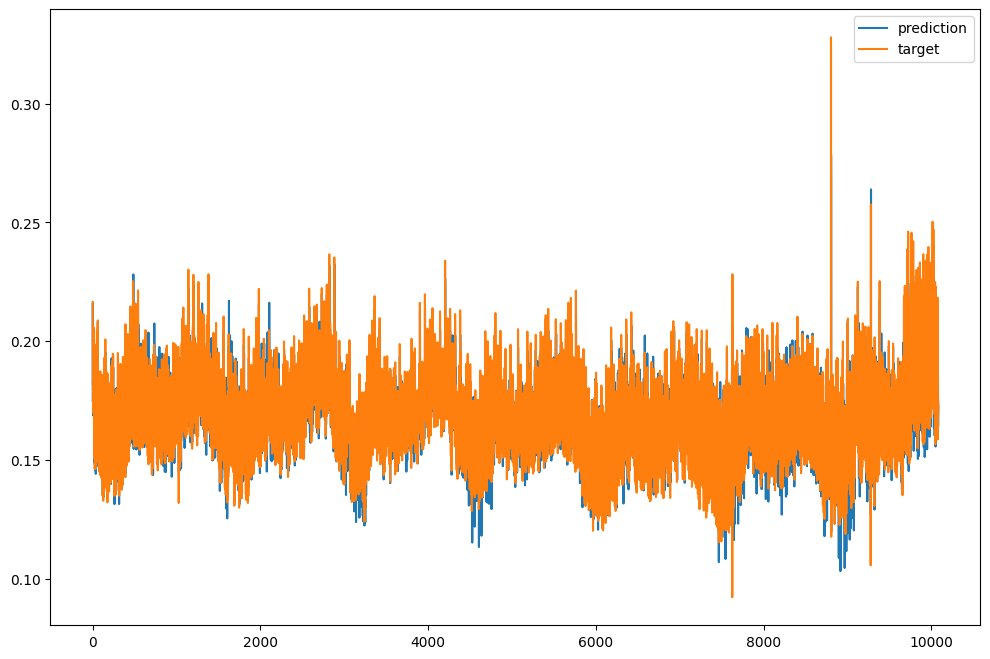

In [114]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [115]:
np.array(pred_list)

array([0.17480768, 0.21613638, 0.19437955, ..., 0.17156908, 0.16379768,
       0.17350702])

In [116]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.216504],
       [0.19432 ],
       [0.181504],
       ...,
       [0.172976],
       [0.169264],
       [0.175408]])

In [117]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [118]:
print(SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

4.772227630019188 %


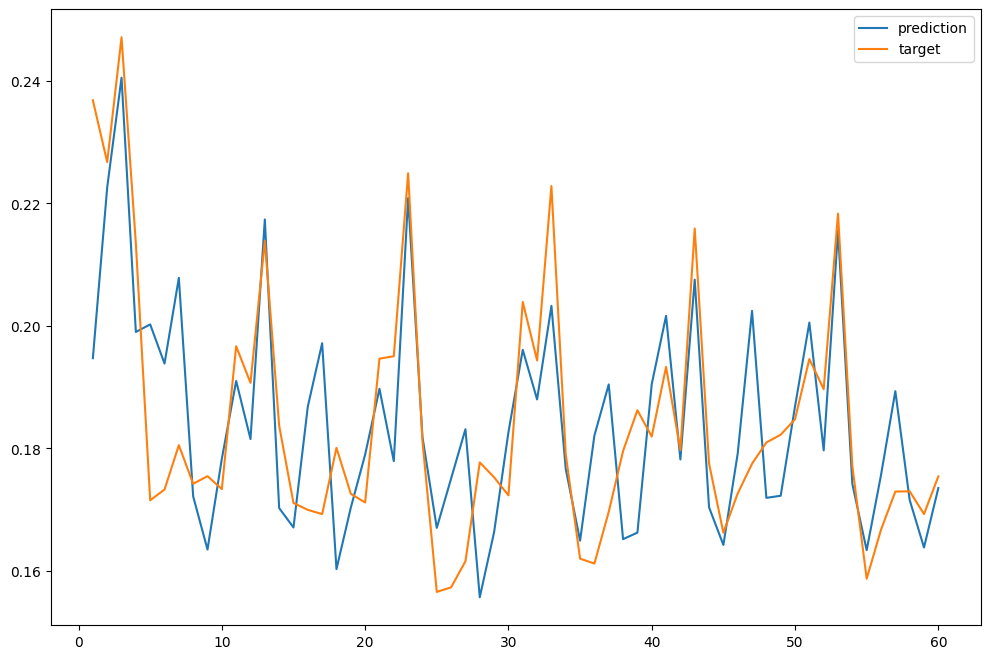

In [119]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [120]:
len(time_list)

10080

In [121]:
np.mean(time_list) 

0.47149165715017016

FIRST

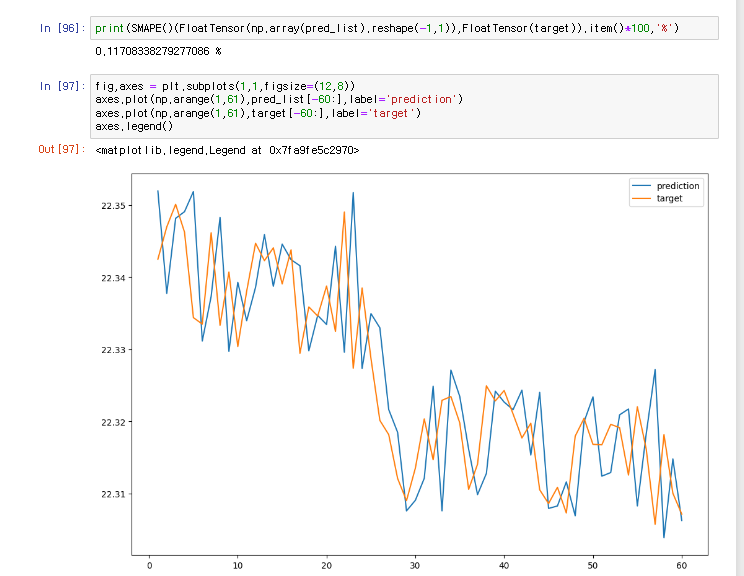